In [1]:
#mount googledrive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchvision import transforms
import os

In [3]:
feature_path = '/content/gdrive/My Drive/University/5th_Year/APS360/Project/Features/'
checkpoint_path = '/content/gdrive/My Drive/University/5th_Year/APS360/Project/Training Model/checkpoints/sample_data/checkpoint'

In [4]:
# !unzip /content/gdrive/MyDrive/features.zip -d /content/

In [5]:
#"/content/Features/Train"
def get_features(batch_size, path_trail):
  master_path= feature_path + path_trail
  dataset = torchvision.datasets.DatasetFolder(master_path, loader=torch.load, extensions=('.tensor'))
  num_workers=1
  feature_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
  return feature_loader

In [6]:
import torchvision.models
alexnet = torchvision.models.alexnet(pretrained=True)
# feature_loader =get_features(batch_size=16,  path="/content/Features/Train")
feature_loader =get_features(batch_size=16,  path_trail="Train")
for img, label in feature_loader:
  print(label)
  break


Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth



tensor([1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1])


In [7]:
class nn_after_feature(nn.Module):
  def __init__(self, hidden_one, hidden_two):
      super(nn_after_feature, self).__init__()
      self.name = "nn_after_feature"
      self.fc1 = nn.Linear(256*6*6, hidden_one)
      self.fc2 = nn.Linear(hidden_one, hidden_two)
      self.fc3 = nn.Linear(hidden_two, 2)

  def forward(self, x):
      x = x.view(-1, 256*6*6)
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      x = self.fc3(x)
      return x

In [8]:
#hyperparamters

hidden_one = 50
hidden_two = 100

In [9]:
model=nn_after_feature(hidden_one, hidden_two)
for img, label in feature_loader:
  out=model(img)
  print(out)
  break

tensor([[-0.0275,  0.0344],
        [-0.0211, -0.0729],
        [-0.0224,  0.0560],
        [-0.0812,  0.0603],
        [ 0.0307,  0.1259],
        [ 0.0220,  0.0785],
        [-0.0093,  0.1876],
        [ 0.0067,  0.0509],
        [-0.0227,  0.0925],
        [-0.0040,  0.1263],
        [-0.0310,  0.0629],
        [-0.0329,  0.0420],
        [ 0.0467, -0.0134],
        [ 0.0068,  0.0591],
        [ 0.0052,  0.1205],
        [-0.0063,  0.1089]], grad_fn=<AddmmBackward>)


In [10]:
def accuracy_transfer_learining(net, loader):
    correct = 0
    total = 0
    for imgs, labels in loader:
        if torch.cuda.is_available():
            imgs = imgs.cuda()
            labels = labels.cuda()
        output=net(imgs)
        pred = output.max(1, keepdim=True)[1] #(get maximum value among the output)
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

model=model.cuda()
val_feature_loader=get_features(36, "Valid")
accuracy_transfer_learining(model, val_feature_loader)

0.7805970149253731

In [11]:
def training_transfer_learning(net, batch_size=1, learning_rate=0.001, momentum=0.9, epcho_limit=10, testing=False):
  train_feature_loader=get_features(batch_size, "Train")
  val_feature_loader=get_features(batch_size, "Valid")
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)

  acc_train_list=[]
  acc_val_list=[]
  epcho_list=[]
  k=0

  for epcho in range(epcho_limit):
    correct=0
    total=0
    k=0
    for input, label in iter(train_feature_loader):
      if torch.cuda.is_available():
          input = input.cuda()
          label = label.cuda()
      output=net(input)
      
      loss = criterion(output, label)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      pred = output.max(1, keepdim=True)[1]
      correct += pred.eq(label.view_as(pred)).sum().item()
      total += input.shape[0]
      k=k+1
      if testing and k>50:
        break
    
    acc_val=accuracy_transfer_learining(net, val_feature_loader)
    acc_train=correct/total
    acc_train_list.append(acc_train)
    acc_val_list.append(acc_val)
    epcho_list.append(epcho)

    if (epcho) %5==0:
      torch.save(net.state_dict(), checkpoint_path +str(batch_size)+"_"+str(learning_rate)+".pth")
      #torch.save(net.state_dict(), "/content/sample_data/checkpoint"+str(batch_size)+"_"+str(learning_rate)+".pth")
      print("epcho: "+str(epcho)+" train acc: "+str(acc_train)+" val acc: "+str(acc_val))
  torch.save(net.state_dict(), checkpoint_path +str(batch_size)+"_"+str(learning_rate)+".pth")
  #torch.save(net.state_dict(), "/content/sample_data/checkpoint"+str(batch_size)+"_"+str(learning_rate)+".pth")
  print("epcho: "+str(epcho)+" train acc: "+str(acc_train)+" val acc: "+str(acc_val))

  plt.title("Training Curve | batch size: "+str(batch_size)+" lr: "+str(learning_rate))
  plt.plot(epcho_list, acc_train_list, label="Train ")
  plt.plot(epcho_list, acc_val_list, label="Validation")
  plt.xlabel("Iterations")
  plt.ylabel("Training Accuracy")
  plt.legend(loc='best')
  plt.show()

epcho: 0 train acc: 0.9616035540511952 val acc: 0.9880597014925373
epcho: 5 train acc: 0.9992595726676539 val acc: 0.991044776119403
epcho: 10 train acc: 0.9998942246668077 val acc: 0.991044776119403
epcho: 15 train acc: 0.9997884493336154 val acc: 0.991044776119403
epcho: 20 train acc: 0.9998942246668077 val acc: 0.991044776119403
epcho: 25 train acc: 0.9998942246668077 val acc: 0.991044776119403
epcho: 30 train acc: 1.0 val acc: 0.991044776119403
epcho: 35 train acc: 1.0 val acc: 0.991044776119403
epcho: 40 train acc: 1.0 val acc: 0.991044776119403
epcho: 45 train acc: 1.0 val acc: 0.991044776119403
epcho: 50 train acc: 1.0 val acc: 0.991044776119403
epcho: 55 train acc: 1.0 val acc: 0.991044776119403
epcho: 59 train acc: 1.0 val acc: 0.991044776119403


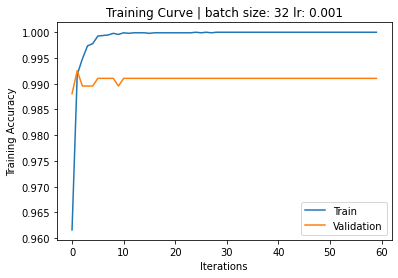

In [12]:
# hidden_one = 50
# hidden_two = 100
model=nn_after_feature(50, 20)
model=model.cuda()
training_transfer_learning(model, learning_rate=0.001, 
                           batch_size=32, epcho_limit=60)

In [14]:
#getting test accuracy for model using AlexNet features 

batch_size = 32
test_feature_loader=get_features(batch_size, "Test")
print("Final test accuracy:", accuracy_transfer_learining(
    model, test_feature_loader))

Final test accuracy: 0.9932203389830508
